# Nenana Ice Classic - Logistic Regression Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import make_pipeline
from category_encoders import WOEEncoder
from sklearn.decomposition import KernelPCA as KPCA

# models
from sklearn.linear_model import LogisticRegressionCV

# evaluation
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn import metrics # accuracy_score

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

In [2]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [3]:
df = pd.read_csv('../data/features_added.csv')

In [4]:
df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipIntensity,precipAccumulation,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,0.0,0.0,...,0.714286,1.30384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

#### How good does my model have to be?

In [5]:
# the thing to beat: 0.9827072152653548
print('Percentage of non-events:')
1 - (df['winningDate'].sum()/df['winningDate'].count())

Percentage of non-events:


0.9827072152653548

#### Create training and testing DataFrames

In [6]:
training_df = pd.read_csv('../data/model_training_data.csv')

In [7]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 1.5+ MB


In [8]:
testing_df = pd.read_csv('../data/model_testing_data.csv')

In [9]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 295.0+ KB


In [10]:
del df
gc.collect()

11

In [11]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [12]:
used_cols = [c for c in training_df.columns if c not in exclude]

In [13]:
no_ma_cols = [c for c in training_df.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [14]:
pprint.pprint(no_ma_cols, compact = True)
pprint.pprint(used_no_ma_cols, compact = True)

['Date', 'moonPhase', 'humidity', 'windSpeed', 'windBearing', 'uvIndex',
 'precipIntensity', 'winningTime', 'daylightHours', 'iceThickness', 'dayOfYear',
 'winningDate', 'precip_rain', 'precip_snow', 'temperatureAvg', 'numHotDays',
 'numColdDays', 'accumulatedSnow']
['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'uvIndex',
 'precipIntensity', 'daylightHours', 'iceThickness', 'dayOfYear', 'precip_rain',
 'precip_snow', 'temperatureAvg', 'numHotDays', 'numColdDays',
 'accumulatedSnow']


---
#### Logistic Regression Baseline Model Excluding Moving Average Features

In [15]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_no_ma_cols].values, training_df[target].values
# TODO: write scoring function and tracking DataFrame
scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [16]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_no_ma_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [17]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.8969957081545065


In [18]:
sns.set_style("whitegrid", {'axes.grid' : False})

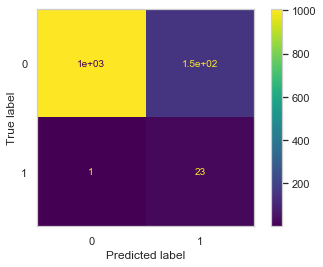

In [19]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

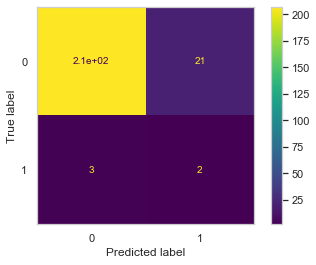

In [20]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [21]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([7.58113064e-04, 5.12488700e-05, 1.40169819e-04, 1.58936281e-03,
       8.28937736e-04])

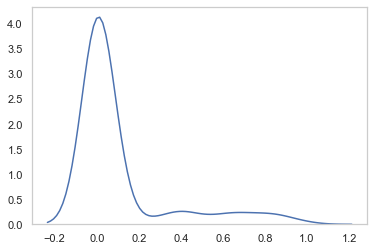

In [22]:
sns.kdeplot(y_pred);

In [23]:
metrics.confusion_matrix(y_test, y_pred > 1e-3)

array([[ 45, 183],
       [  0,   5]])

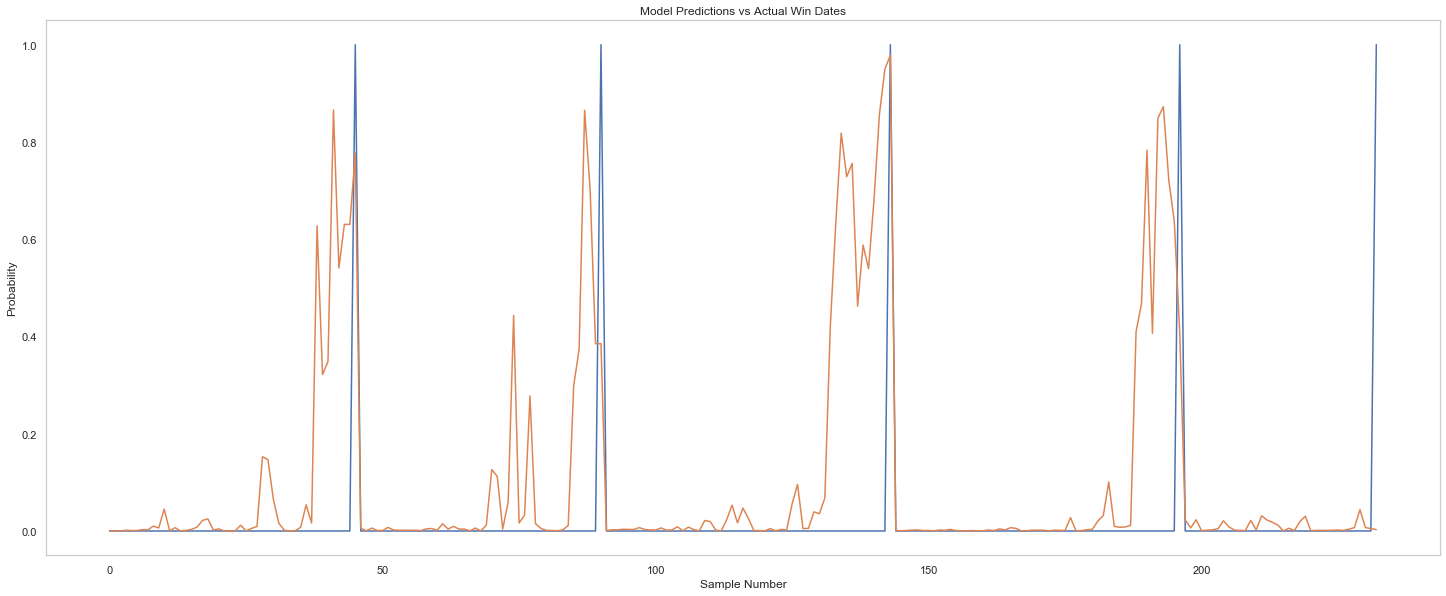

In [24]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

In [25]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)

[(13, 2.0375735061419484),
 (14, -1.9951827561425215),
 (3, 1.7479481184185908),
 (0, 1.5792839407674724),
 (2, 1.4594368681638288),
 (7, 1.3567292858295634),
 (8, 1.0957220540414823),
 (11, 0.9598944765778575),
 (4, 0.7808876681905104),
 (1, 0.22621852423921257),
 (5, 0.13704937702757172),
 (9, 0.13704937702757172),
 (10, 0.13704937702757172),
 (6, -0.10021461184895951),
 (12, 0.08925507917265287)]

In [26]:
# list the feature names so the top feature list can be made
feature_names = []
for n, v in enumerate(used_no_ma_cols):
    feature_names.append((n, v))
pprint.pprint(feature_names, compact = True)

[(0, 'moonPhase'), (1, 'humidity'), (2, 'windSpeed'), (3, 'windBearing'),
 (4, 'uvIndex'), (5, 'precipIntensity'), (6, 'daylightHours'),
 (7, 'iceThickness'), (8, 'dayOfYear'), (9, 'precip_rain'), (10, 'precip_snow'),
 (11, 'temperatureAvg'), (12, 'numHotDays'), (13, 'numColdDays'),
 (14, 'accumulatedSnow')]


In [27]:
best_no_ma_features = ['numColdDays', 'accumulatedSnow', 'daylightHours', 'windSpeed',
                       'iceThickness', 'dayOfYear', 'temperatureAvg']

---
#### Logistic Regression Model Using Top Features From Baseline Excluding Moving Average Features Model

In [28]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[best_no_ma_features].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [29]:
pipe.fit(X_train, y_train)
X_test = testing_df[best_no_ma_features]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [30]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.8884120171673819


In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})

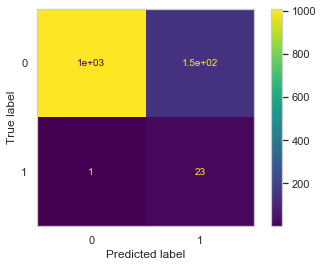

In [32]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

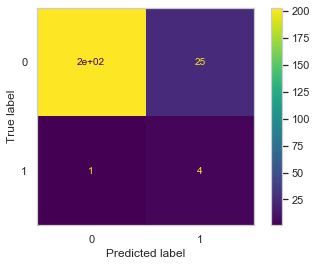

In [33]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [34]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00097478, 0.00097478, 0.00638756, 0.00209894, 0.00209894])

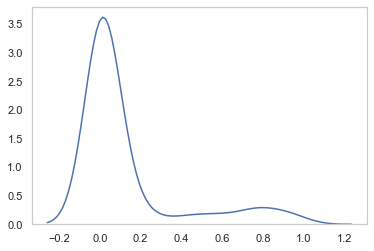

In [35]:
sns.kdeplot(y_pred);

In [36]:
metrics.confusion_matrix(y_test, y_pred > 0.15)

array([[190,  38],
       [  1,   4]])

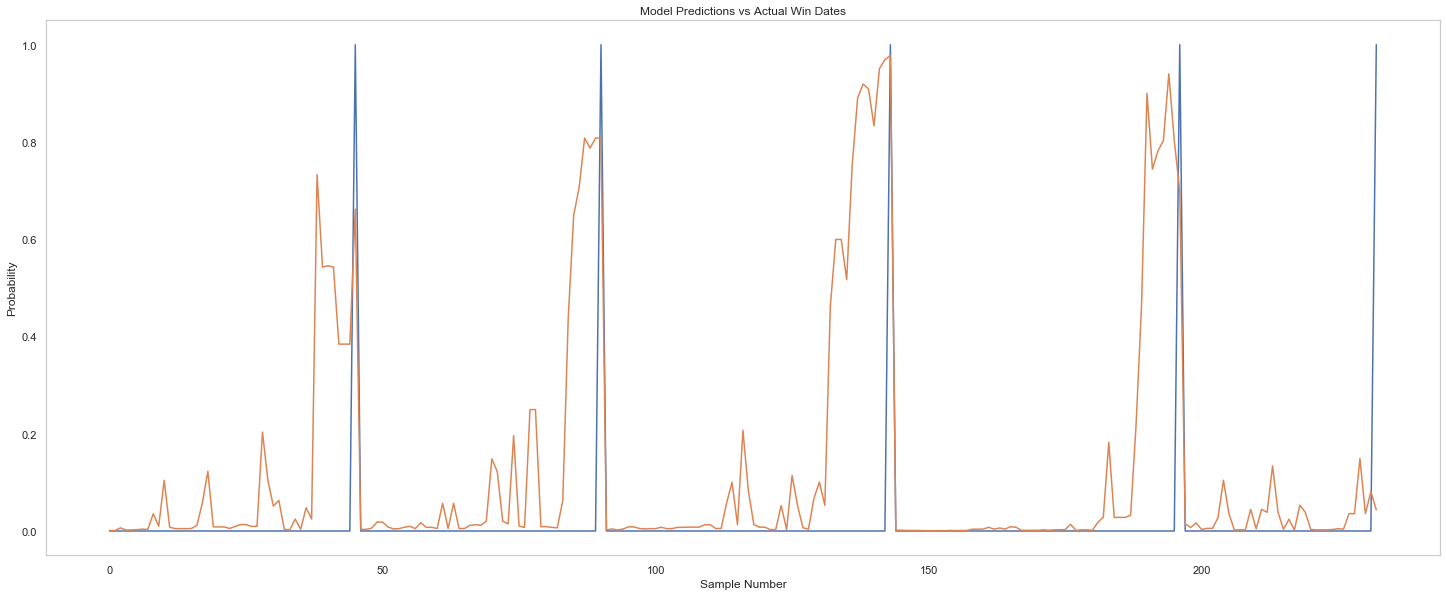

In [37]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Baseline Logistic Regression Model Including Moving Average Features

In [38]:
# baseline Logistic Regression model using all features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [39]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [40]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9742489270386266


In [41]:
sns.set_style("whitegrid", {'axes.grid' : False})

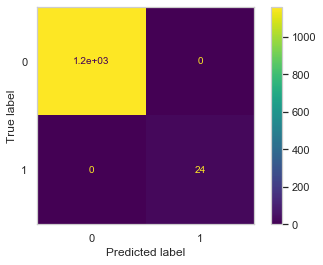

In [42]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

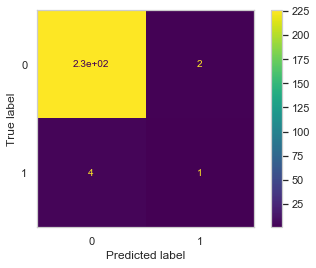

In [43]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [44]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.24125772e-15, 4.81953709e-13, 4.29567045e-09, 1.52868210e-11,
       2.30724203e-08])

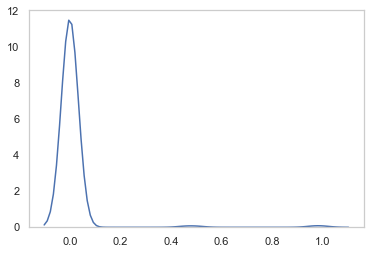

In [45]:
sns.kdeplot(y_pred);

In [46]:
metrics.confusion_matrix(y_test, y_pred > 1e-10)

array([[137,  91],
       [  1,   4]])

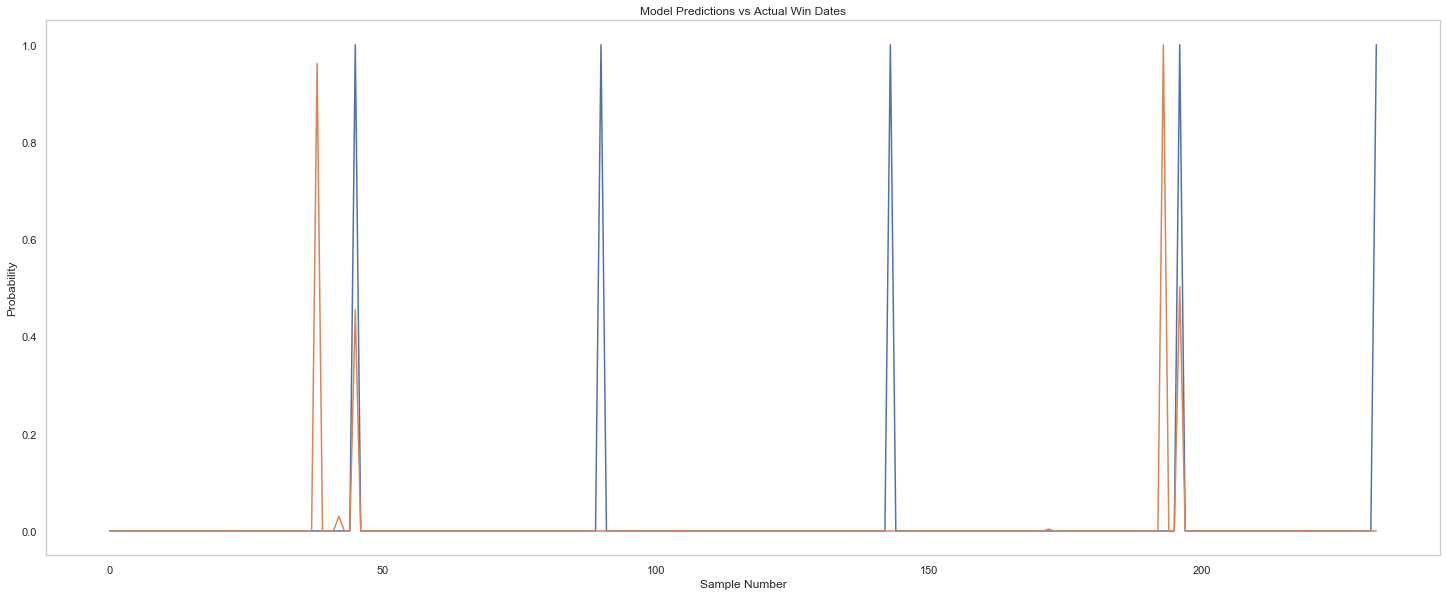

In [47]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

Based on the confusion matrices, this model is overfitted.

In [48]:
pprint.pprint(used_cols, compact = True)

['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'uvIndex',
 'precipIntensity', 'daylightHours', 'iceThickness', 'dayOfYear', 'precip_rain',
 'precip_snow', 'temperatureAvg', 'numHotDays', 'numColdDays',
 'accumulatedSnow', 'humidity_MA3', 'humidity_MA-slope3', 'humidity_MA-accel3',
 'humidity_MA-std_dev3', 'humidity_MA5', 'humidity_MA-slope5',
 'humidity_MA-accel5', 'humidity_MA-std_dev5', 'humidity_MA7',
 'humidity_MA-slope7', 'humidity_MA-accel7', 'humidity_MA-std_dev7',
 'humidity_MA10', 'humidity_MA-slope10', 'humidity_MA-accel10',
 'humidity_MA-std_dev10', 'windSpeed_MA3', 'windSpeed_MA-slope3',
 'windSpeed_MA-accel3', 'windSpeed_MA-std_dev3', 'windSpeed_MA5',
 'windSpeed_MA-slope5', 'windSpeed_MA-accel5', 'windSpeed_MA-std_dev5',
 'windSpeed_MA7', 'windSpeed_MA-slope7', 'windSpeed_MA-accel7',
 'windSpeed_MA-std_dev7', 'windSpeed_MA10', 'windSpeed_MA-slope10',
 'windSpeed_MA-accel10', 'windSpeed_MA-std_dev10', 'windBearing_MA3',
 'windBearing_MA-slope3', 'windBearing_MA-acce

---
#### Initial Approach
At this point, feature dimensionality was high. Initially, I dealt with it by fitting the model and pulling out the most important features by hand (measured by coefficient weights).

In [49]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:51]

[(30, 4.384435223453516),
 (61, 4.075040770389072),
 (41, 3.526612480526657),
 (14, -3.440293120856861),
 (46, -3.4393531706627645),
 (78, 3.361597157494932),
 (17, 3.15873693346884),
 (48, 3.110941094249435),
 (112, -3.100617471793507),
 (32, 3.0904287556329653),
 (119, -3.0271600074413727),
 (35, -2.985538956165891),
 (121, -2.8791263078077263),
 (72, 2.724944454617135),
 (123, 2.721102198028567),
 (129, -2.710864963991194),
 (39, 2.6625195406282005),
 (62, -2.56158414039637),
 (150, -2.484997826027205),
 (38, -2.4294026672626536),
 (138, 2.4208374343330394),
 (68, 2.4133096985388733),
 (45, 2.378617544680961),
 (27, -2.3443075338362718),
 (153, -2.3437909917797652),
 (117, 2.3047772544066247),
 (94, -2.2392720047667405),
 (21, 2.219911079712747),
 (56, 2.2110794043208384),
 (23, -2.176050148374703),
 (54, -2.1598359580578825),
 (127, -2.0754666669561046),
 (47, -2.041231330320688),
 (44, 2.025900695569803),
 (108, 1.943145213693464),
 (149, -1.9422259935099118),
 (28, 1.930147598126

In [50]:
# list the feature names so the top 30 feature list can be made
feature_names = []
for n, v in enumerate(used_cols):
    feature_names.append((n, v))
pprint.pprint(feature_names, compact = True)

[(0, 'moonPhase'), (1, 'humidity'), (2, 'windSpeed'), (3, 'windBearing'),
 (4, 'uvIndex'), (5, 'precipIntensity'), (6, 'daylightHours'),
 (7, 'iceThickness'), (8, 'dayOfYear'), (9, 'precip_rain'), (10, 'precip_snow'),
 (11, 'temperatureAvg'), (12, 'numHotDays'), (13, 'numColdDays'),
 (14, 'accumulatedSnow'), (15, 'humidity_MA3'), (16, 'humidity_MA-slope3'),
 (17, 'humidity_MA-accel3'), (18, 'humidity_MA-std_dev3'), (19, 'humidity_MA5'),
 (20, 'humidity_MA-slope5'), (21, 'humidity_MA-accel5'),
 (22, 'humidity_MA-std_dev5'), (23, 'humidity_MA7'), (24, 'humidity_MA-slope7'),
 (25, 'humidity_MA-accel7'), (26, 'humidity_MA-std_dev7'),
 (27, 'humidity_MA10'), (28, 'humidity_MA-slope10'),
 (29, 'humidity_MA-accel10'), (30, 'humidity_MA-std_dev10'),
 (31, 'windSpeed_MA3'), (32, 'windSpeed_MA-slope3'),
 (33, 'windSpeed_MA-accel3'), (34, 'windSpeed_MA-std_dev3'),
 (35, 'windSpeed_MA5'), (36, 'windSpeed_MA-slope5'),
 (37, 'windSpeed_MA-accel5'), (38, 'windSpeed_MA-std_dev5'),
 (39, 'windSpeed_MA7

In [51]:
# Top 20 features by coefficient
lr_best_cols = ['humidity_MA-std_dev10', 'windBearing_MA-accel10', 'windSpeed_MA-accel7', 'accumulatedSnow', 'windSpeed_MA-std_dev10',
                'uvIndex_MA-std_dev10', 'humidity_MA-accel3', 'windBearing_MA-slope3', 'temperatureAvg_MA-slope3', 'windSpeed_MA-slope3',
                'temperatureAvg_MA7', 'windSpeed_MA5', 'temperatureAvg_MA-accel7', 'uvIndex_MA-slope7', 'temperatureAvg_MA10',
                'numHotDays_MA-accel3', 'windSpeed_MA7', 'windBearing_MA-std_dev10', 'numColdDays_MA-std_dev5', 'windSpeed_MA-std_dev5']

In [52]:
# check correlations in top 20 features
training_df[lr_best_cols].corr()

,humidity_MA-std_dev10,windBearing_MA-accel10,windSpeed_MA-accel7,accumulatedSnow,windSpeed_MA-std_dev10,uvIndex_MA-std_dev10,humidity_MA-accel3,windBearing_MA-slope3,temperatureAvg_MA-slope3,windSpeed_MA-slope3,temperatureAvg_MA7,windSpeed_MA5,temperatureAvg_MA-accel7,uvIndex_MA-slope7,temperatureAvg_MA10,numHotDays_MA-accel3,windSpeed_MA7,windBearing_MA-std_dev10,numColdDays_MA-std_dev5,windSpeed_MA-std_dev5
humidity_MA-std_dev10,1.000000,0.002553,0.008206,0.141324,0.309508,0.039723,-0.002406,0.007596,-0.039123,0.002258,-0.009074,0.077619,0.003363,-0.007769,0.011775,-0.014661,0.085221,0.022343,0.053026,0.202402
windBearing_MA-accel10,0.002553,1.000000,-0.074744,-0.010242,0.016052,0.020266,-0.008472,0.453095,-0.223695,-0.090400,0.108894,0.037285,-0.270281,-0.066359,0.060108,-0.104430,0.070998,0.003014,-0.081288,0.036175
windSpeed_MA-accel7,0.008206,-0.074744,1.000000,0.001420,0.005150,-0.003317,-0.023754,-0.106864,0.101020,0.649114,-0.002804,-0.227041,0.198968,0.022024,0.002194,-0.000417,-0.082454,0.025001,0.019308,-0.091748
accumulatedSnow,0.141324,-0.010242,0.001420,1.000000,-0.174879,0.111330,-0.007352,-0.010027,0.013589,-0.008258,0.058856,-0.166935,0.008388,-0.020248,0.059681,0.019966,-0.168947,-0.080550,-0.088141,-0.141371
windSpeed_MA-std_dev10,0.309508,0.016052,0.005150,-0.174879,1.000000,-0.142821,0.010812,0.017543,-0.015841,-0.018619,-0.142661,0.563139,0.001152,-0.038917,-0.139437,-0.010330,0.607490,0.208153,0.140655,0.735121
uvIndex_MA-std_dev10,0.039723,0.020266,-0.003317,0.111330,-0.142821,1.000000,0.004167,0.013719,0.024392,0.006105,0.384669,-0.065899,-0.016872,0.406239,0.383659,0.033028,-0.078214,0.017722,-0.270415,-0.090836
humidity_MA-accel3,-0.002406,-0.008472,-0.023754,-0.007352,0.010812,0.004167,1.000000,0.127988,0.051801,-0.066151,-0.007988,0.020329,0.016260,0.036944,-0.006976,-0.045306,0.014131,0.000204,0.014290,-0.003598
windBearing_MA-slope3,0.007596,0.453095,-0.106864,-0.010027,0.017543,0.013719,0.127988,1.000000,-0.107163,-0.159190,0.040436,0.032687,-0.009689,-0.023061,0.031569,-0.116531,0.034911,-0.007352,-0.037233,0.026908
temperatureAvg_MA-slope3,-0.039123,-0.223695,0.101020,0.013589,-0.015841,0.024392,0.051801,-0.107163,1.000000,0.230362,-0.104714,-0.029617,0.708019,0.111230,-0.095344,0.231718,-0.039956,0.002357,0.105918,-0.022455
windSpeed_MA-slope3,0.002258,-0.090400,0.649114,-0.008258,-0.018619,0.006105,-0.066151,-0.159190,0.230362,1.000000,0.006024,-0.070303,0.157098,0.055487,0.008790,0.080744,-0.067077,0.032843,0.024591,0.005004


This resulted in some collinear features, as well as inter-related features.

---
#### Logistic Regression Model Using Top 20 Features From Baseline Model

In [53]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[lr_best_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [54]:
pipe.fit(X_train, y_train)
X_test = testing_df[lr_best_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [55]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9613733905579399


In [56]:
sns.set_style("whitegrid", {'axes.grid' : False})

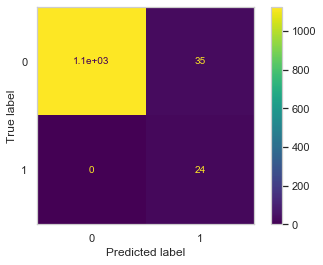

In [57]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

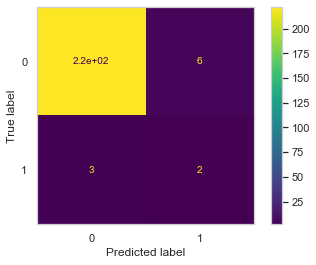

In [58]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [59]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([4.52304540e-23, 6.17042811e-19, 1.81535935e-14, 2.62560279e-23,
       1.79807510e-17])

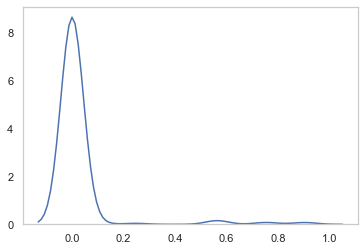

In [60]:
sns.kdeplot(y_pred);

In [61]:
metrics.confusion_matrix(y_test, y_pred > 0.15)

array([[221,   7],
       [  3,   2]])

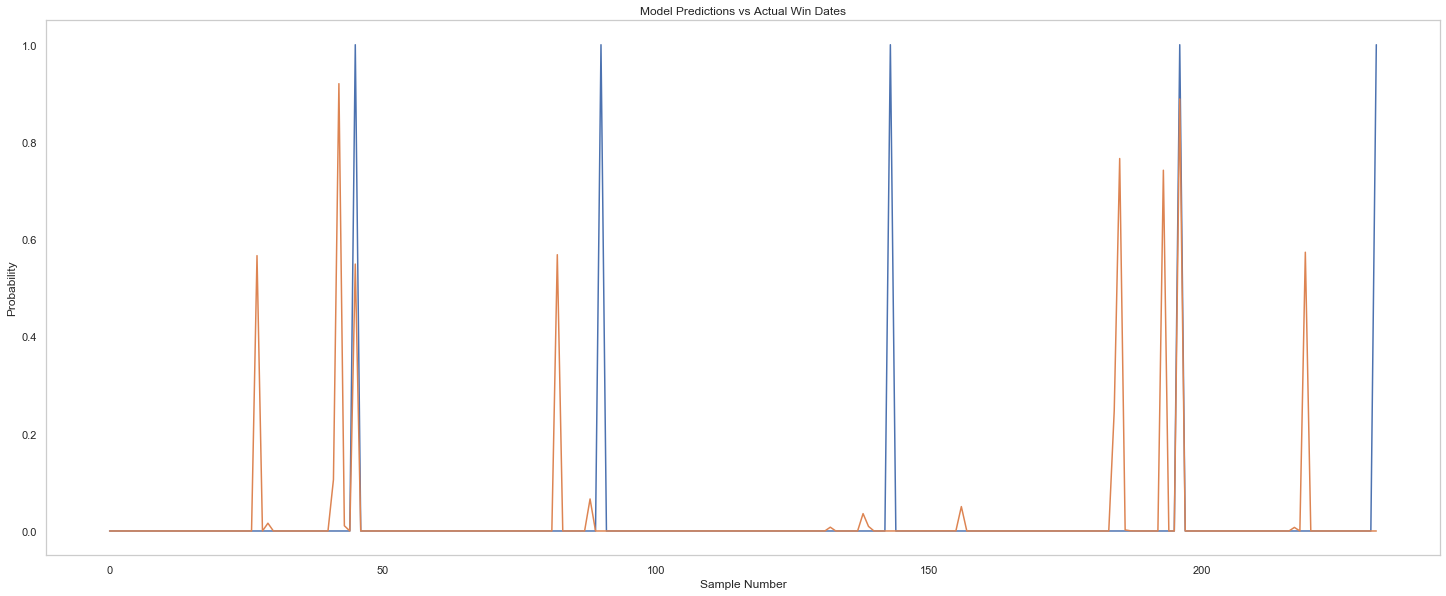

In [62]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Logistic Regression Model Using Adjusted Best Feature List
I decided to exclude features that derived from the same base. I thought this might reduce overfitting by diversifying the base features used.

In [63]:
# top diverse features
adj_lr_best_cols = ['humidity_MA-std_dev10', 'windBearing_MA-accel10', 'windSpeed_MA-accel7', 'accumulatedSnow', 'uvIndex_MA-std_dev10',
                    'temperatureAvg_MA-slope3', 'numHotDays_MA-accel3', 'numColdDays_MA-std_dev5', 'precipIntensity_MA-std_dev10',
                    'iceThickness_MA-slope10', 'daylightHours', 'dayOfYear']

In [64]:
# Logistic Regression model using top diverse features from baseline
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = training_df[adj_lr_best_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [65]:
pipe.fit(X_train, y_train)
X_test = testing_df[adj_lr_best_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [66]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9699570815450643


In [67]:
sns.set_style("whitegrid", {'axes.grid' : False})

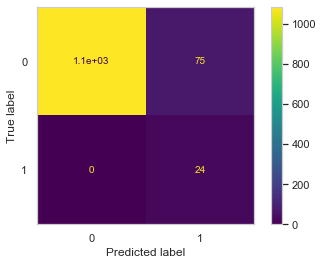

In [68]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

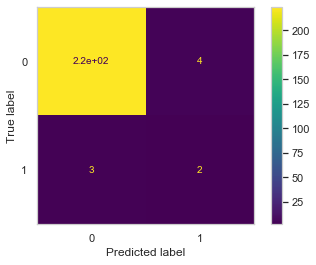

In [69]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [70]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.25932921e-09, 2.94290311e-07, 4.49994453e-07, 1.03834597e-08,
       4.12029857e-04])

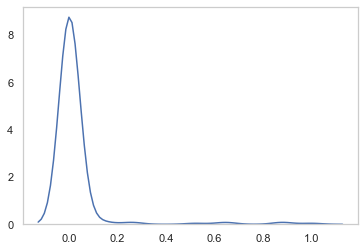

In [71]:
sns.kdeplot(y_pred);

In [72]:
metrics.confusion_matrix(y_test, y_pred > 1e-4)

array([[150,  78],
       [  1,   4]])

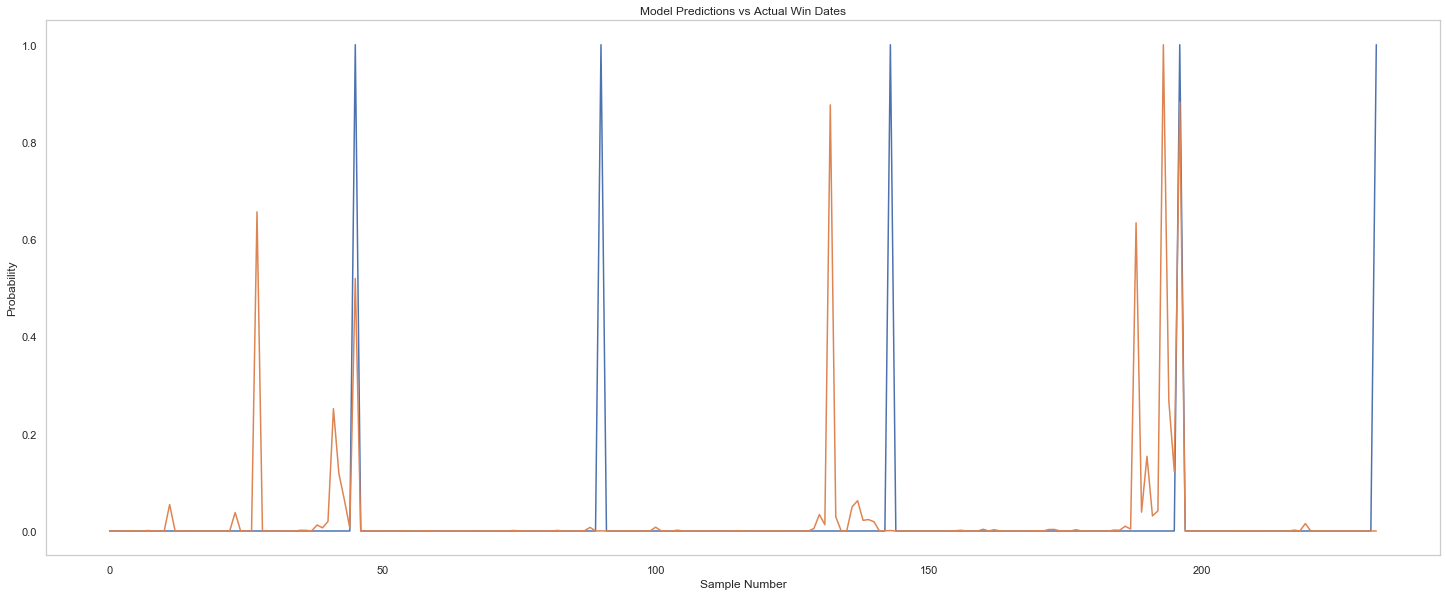

In [73]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Principal Component Analysis
It was suggested to me that PCA would be quicker and potentially more effective than my initial approach.

In [74]:
# Logistic Regression model using PCA
pca_exclude = ['precip_snow', 'precip_rain', 'winningDate', 'winningTime', 'Date']
used_cols = [c for c in training_df.columns if c not in pca_exclude]

target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 30,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


lorem ipsum

In [75]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [76]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9742489270386266


In [77]:
sns.set_style("whitegrid", {'axes.grid' : False})

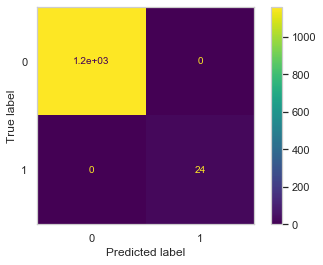

In [78]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

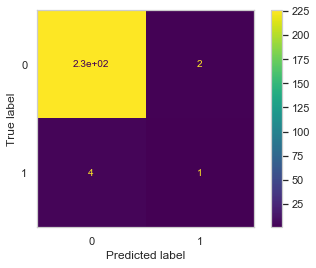

In [79]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [80]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([6.54446242e-124, 1.86395436e-113, 1.77608902e-098, 2.17668224e-100,
       5.06511037e-092])

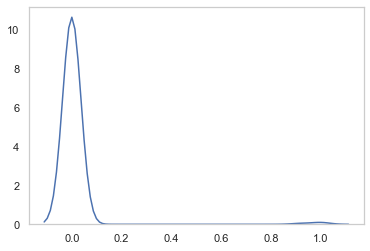

In [81]:
sns.kdeplot(y_pred);

In [82]:
metrics.confusion_matrix(y_test, y_pred > 1e-70)

array([[113, 115],
       [  1,   4]])

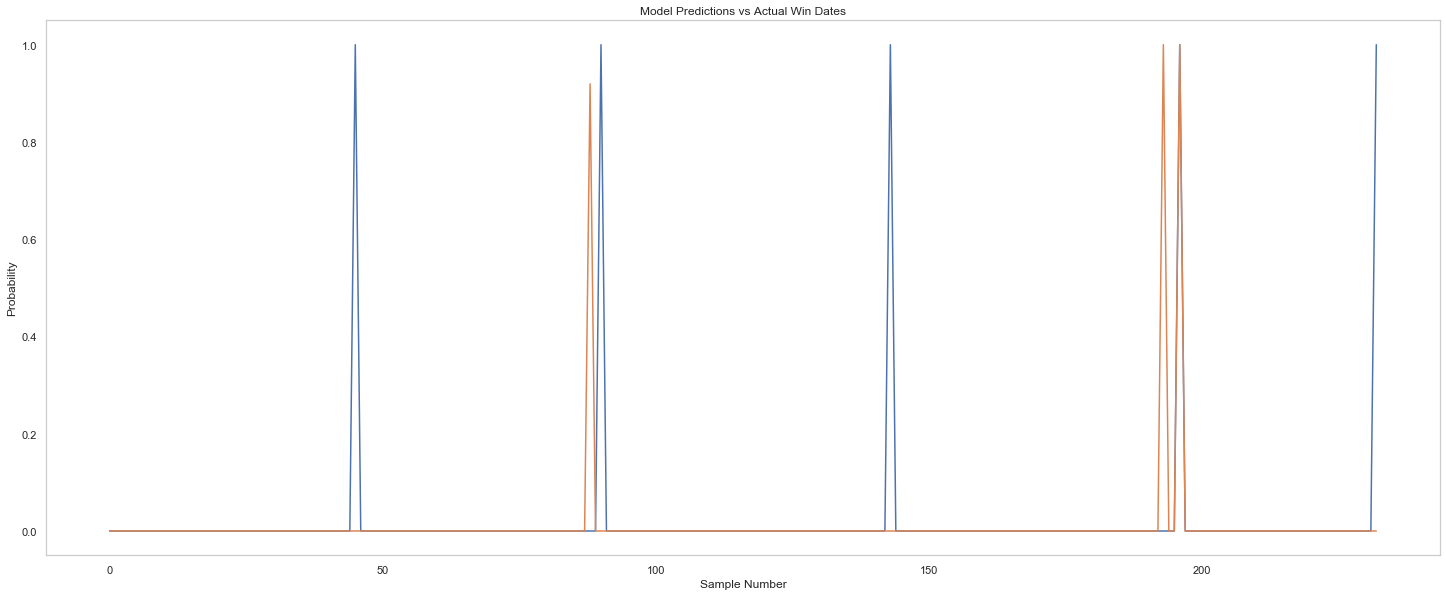

In [83]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 20 principal components

In [84]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 20,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [85]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [86]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9785407725321889


In [87]:
sns.set_style("whitegrid", {'axes.grid' : False})

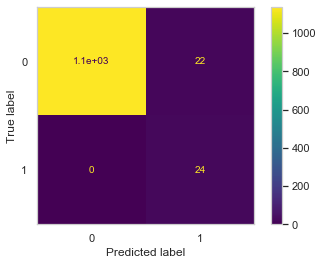

In [88]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

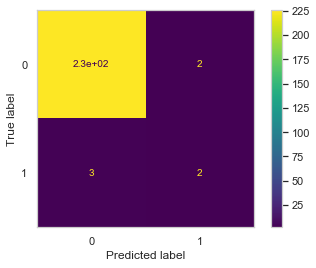

In [89]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [90]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([4.73076005e-15, 1.71486296e-18, 5.14015909e-15, 3.07282778e-15,
       2.23249392e-12])

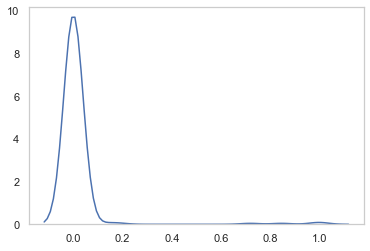

In [91]:
sns.kdeplot(y_pred);

In [92]:
metrics.confusion_matrix(y_test, y_pred > 1e-8)

array([[130,  98],
       [  1,   4]])

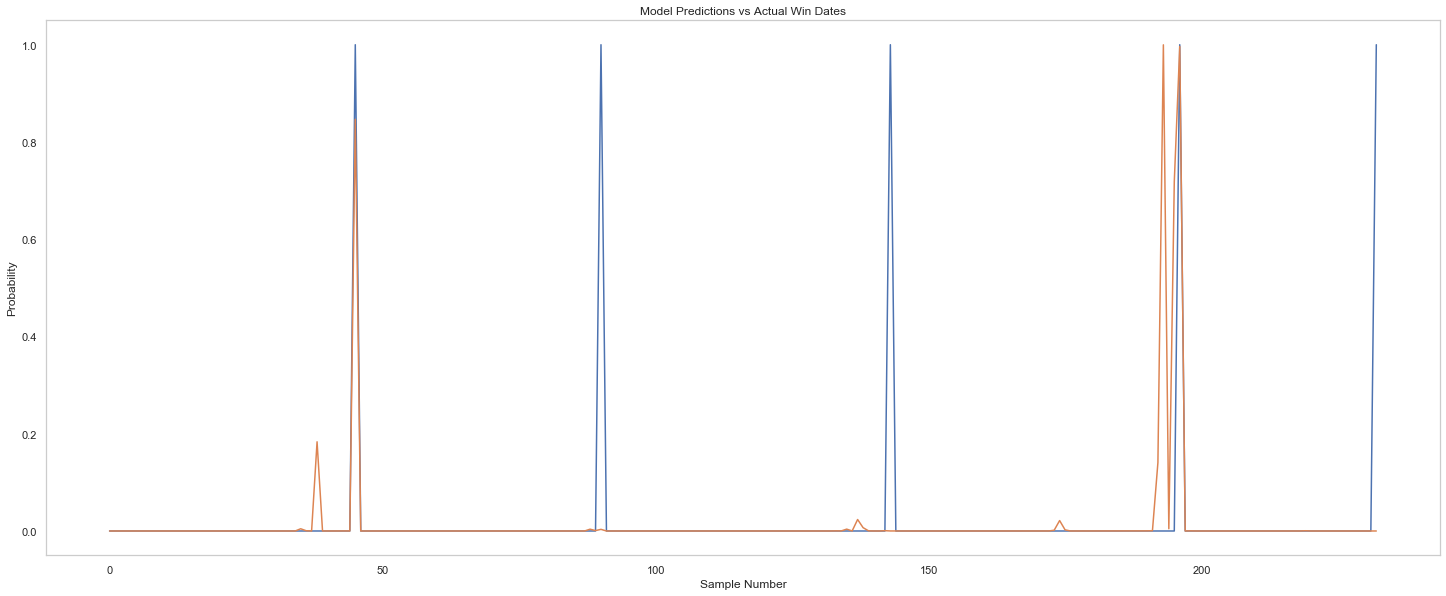

In [93]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 10 principal components

In [94]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 10,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [95]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [96]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9613733905579399


In [97]:
sns.set_style("whitegrid", {'axes.grid' : False})

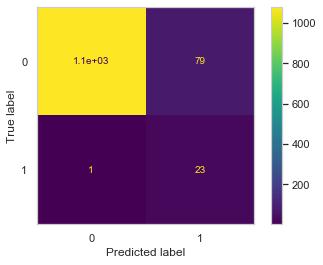

In [98]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

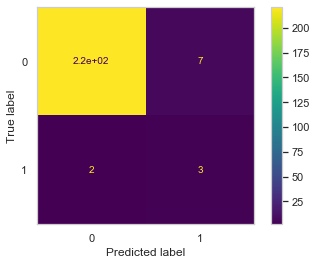

In [99]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [100]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.37773769e-14, 8.33538902e-14, 1.87872627e-13, 2.12476430e-13,
       4.90932396e-12])

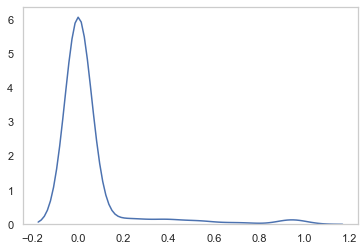

In [101]:
sns.kdeplot(y_pred);

In [102]:
metrics.confusion_matrix(y_test, y_pred > 1e-3)

array([[175,  53],
       [  0,   5]])

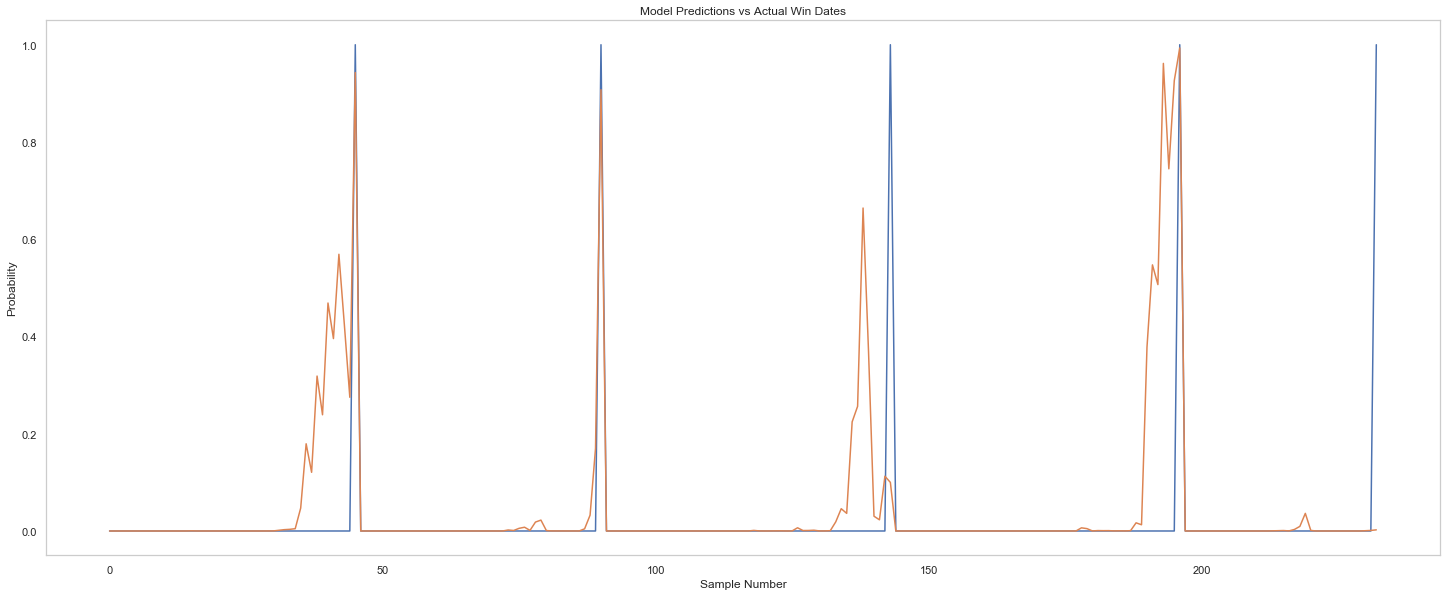

In [103]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 5 principal components

In [104]:
# Logistic Regression model using PCA
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = training_df[used_cols].values, training_df[target].values

scores = cross_validate(pipe, X_train, y_train, cv = TimeSeriesSplit(),
                        scoring=['f1_weighted', 'precision_weighted', 'recall_weighted',
                                 'accuracy', 'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: nan +/- nan
precision_weighted: nan +/- nan
recall_weighted: nan +/- nan
accuracy: nan +/- nan
roc_auc: nan +/- nan


In [105]:
pipe.fit(X_train, y_train)
X_test = testing_df[used_cols]
y_test = testing_df[target]
y_pred = pipe.predict(X_test)

In [106]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))

Test set accuracy: 0.9227467811158798


In [107]:
sns.set_style("whitegrid", {'axes.grid' : False})

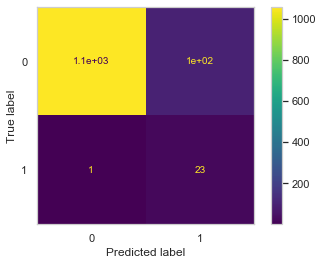

In [108]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

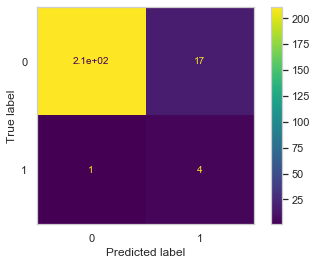

In [109]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [110]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([6.02132219e-07, 2.07561105e-06, 3.37762166e-06, 7.05817011e-06,
       3.59034281e-05])

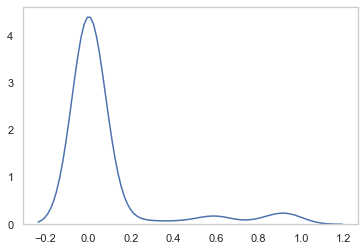

In [111]:
sns.kdeplot(y_pred);

In [112]:
metrics.confusion_matrix(y_test, y_pred > 0.09)

array([[201,  27],
       [  0,   5]])

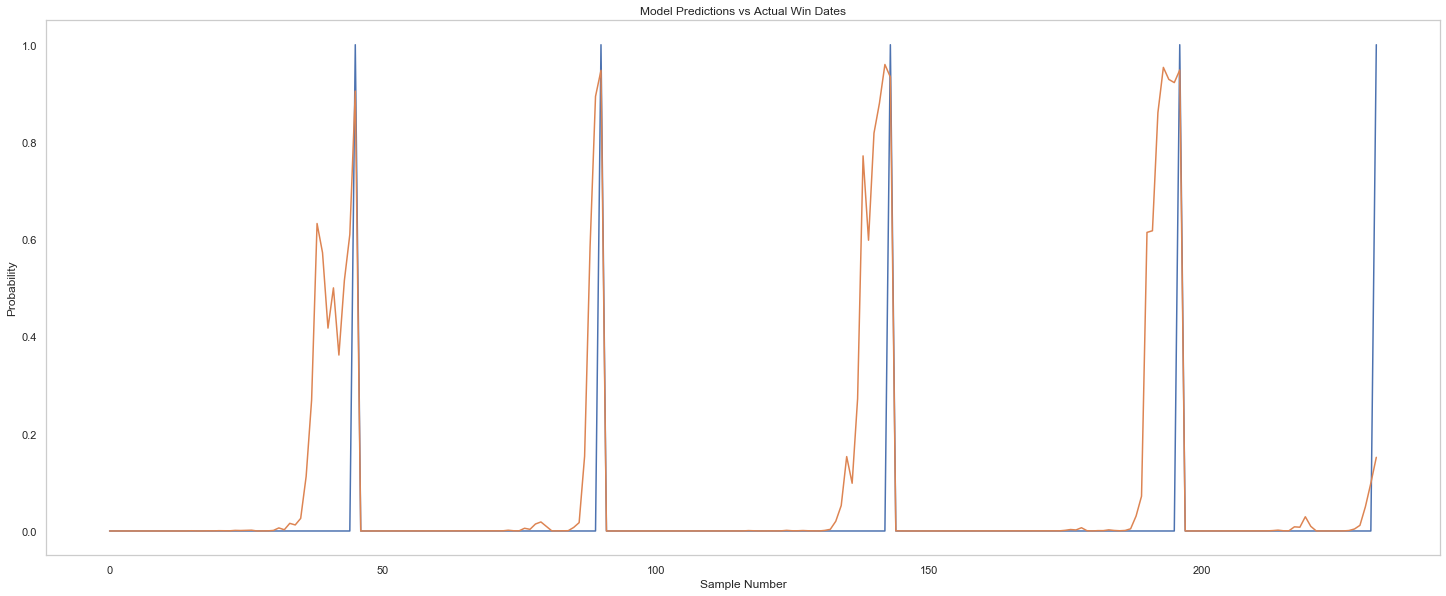

In [113]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Model Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()